# Plot the horizontal kinetic energy of each mode along the beam path for different experiments

In [ ]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.colormaps["gist_earth"]
from datetime import timedelta

# import filtering
import numpy as np
import dask
dask.config.set({'logging.distributed': 'error'})
from dask.distributed import Client,default_client
import xrft


client = tt.startdask()
client

<Client: 'tcp://127.0.0.1:40947' processes=7 threads=28, memory=112.00 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40947,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:39145,Total threads: 4
Dashboard: /proxy/40747/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:33435,


## First draft a function to calculate N(z)

$ \large N = \frac{-g}{\rho}\frac{\partial \rho}{\partial z} $


In [3]:
trange = 50
to_process = {
    "full-20": {
        "data":tt.collect_data(
            exptname="full-20",
            rawdata = ["rho"],
            lfiltered = "10000-lowpass"
        ).sel(yb = slice(-50,50)).drop("cst").chunk({"zl":-1,"time":10}).persist()
        },
    "blank-20": {
        "data":tt.collect_data(
            exptname="blank-20",
            rawdata = ["rho","u","v"],
            timerange = (1000 - trange,1000 + trange)
        ).sel(yb = slice(-50,50))
    },
    "blank-20_filtered": {
        "data":tt.collect_data(
            exptname="blank-20",
            rawdata = ["rho"],
            lfiltered = "1000-lowpass"
        ).sel(yb = slice(-50,50)).drop("cst").chunk({"zl":-1,"time":10}).persist()
    },
    # "ideal-20": {
    #     "data":tt.collect_data(
    #         exptname="ideal-20",
    #         rawdata = ["rho","u","v"],
    #         timerange = (1000 - trange,1000 + trange)
    #     ).sel(yb = slice(-50,50)).isel(zl = slice(0,80))
    # },
    "smooth-20": {
        "data":tt.collect_data(
            exptname="smooth-20",
            rawdata = ["rho"],
            lfiltered = "10000-lowpass"
        ).sel(yb = slice(-50,50)).drop("cst").chunk({"zl":-1,"time":10}).persist()
        },
    }

Timerange as inferred from lfiltered data: (9950.0, 10049.0)
loading rho...	done.


/jobfs/116474488.gadi-pbs/ipykernel_4125190/82984304.py:8: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ).sel(yb = slice(-50,50)).drop("cst").chunk({"zl":-1,"time":10}).persist()


loading rho...	done.
loading u...	done.
loading v...	done.
Timerange as inferred from lfiltered data: (950.0, 1049.0)
loading rho...	done.


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/array/core.py:4839: PerformanceWarning: Increasing number of chunks by factor of 81
  result = blockwise(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/array/core.py:4839: PerformanceWarning: Increasing number of chunks by factor of 81
  result = blockwise(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/array/core.py:4839: PerformanceWarning: Increasing number of chunks by factor of 81
  result = blockwise(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/array/core.py:4839: PerformanceWarning: Increasing number of chunks by factor of 81
  result = blockwise(
/jobfs/116474488.gadi-pbs/ipykernel_4125190/82984304.py:22: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ).sel(yb = slice(-50,50)).drop("cst").chunk({"zl":-1,"time":10}).persist

Timerange as inferred from lfiltered data: (9950.0, 10049.0)
loading rho...	done.


/jobfs/116474488.gadi-pbs/ipykernel_4125190/82984304.py:36: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ).sel(yb = slice(-50,50)).drop("cst").chunk({"zl":-1,"time":10}).persist()


In [4]:
for expt in to_process:
    print(expt)
    u = tt.VerticalModes(to_process[expt]["data"].isel(zl = slice(10,None)),"u")
    v = tt.VerticalModes(to_process[expt]["data"].isel(zl = slice(10,None)),"v")
    u_horiz = u.hztl
    u_vrtl = u.vrtl
    # v_horiz = (to_process[expt]["data"]["v"].fillna(0) * vrtl).integrate("zl")
    v_horiz = v.hztl
    v_vrtl = v.vrtl
    ## Now calculate the KE and integrate in time
    KE = 0.5 * (((u_vrtl * u_horiz)**2 + (v_vrtl * v_horiz)**2)).mean("time").integrate("yb")
    to_process[expt]["KE"] = KE.load()
    # get the time in the middle of dataset range
    midtime = int(round(np.mean(to_process[expt]["data"]["u"].time.values)))
    # tt.save(
    #     to_process[expt]["KE"],
    #     f"KE_alongbeam/KE-{midtime}.nc"
    #     )

full-20


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in sqrt
  return fu

blank-20


2024-05-26 03:19:37,704 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'original-open_dataset-rho-16abdc47ec9b4f5e7075b766f546eb2c' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x14a8a086e560>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=<xarray.backends.netCDF4_.NetCDF4ArrayWrapper object at 0x14a7a75d85c0>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None), slice(None, None, None)))))),), {})
new run_spec: (<function execute_task at 0x14a8a086e560>, (ImplicitToExplicitIndexingAdap

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 58.31 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


blank-20_filtered


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 58.54 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


smooth-20


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 58.54 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Text(0.5, 0, '<-- Tassie  (km)  Macquarie Ridge -->')

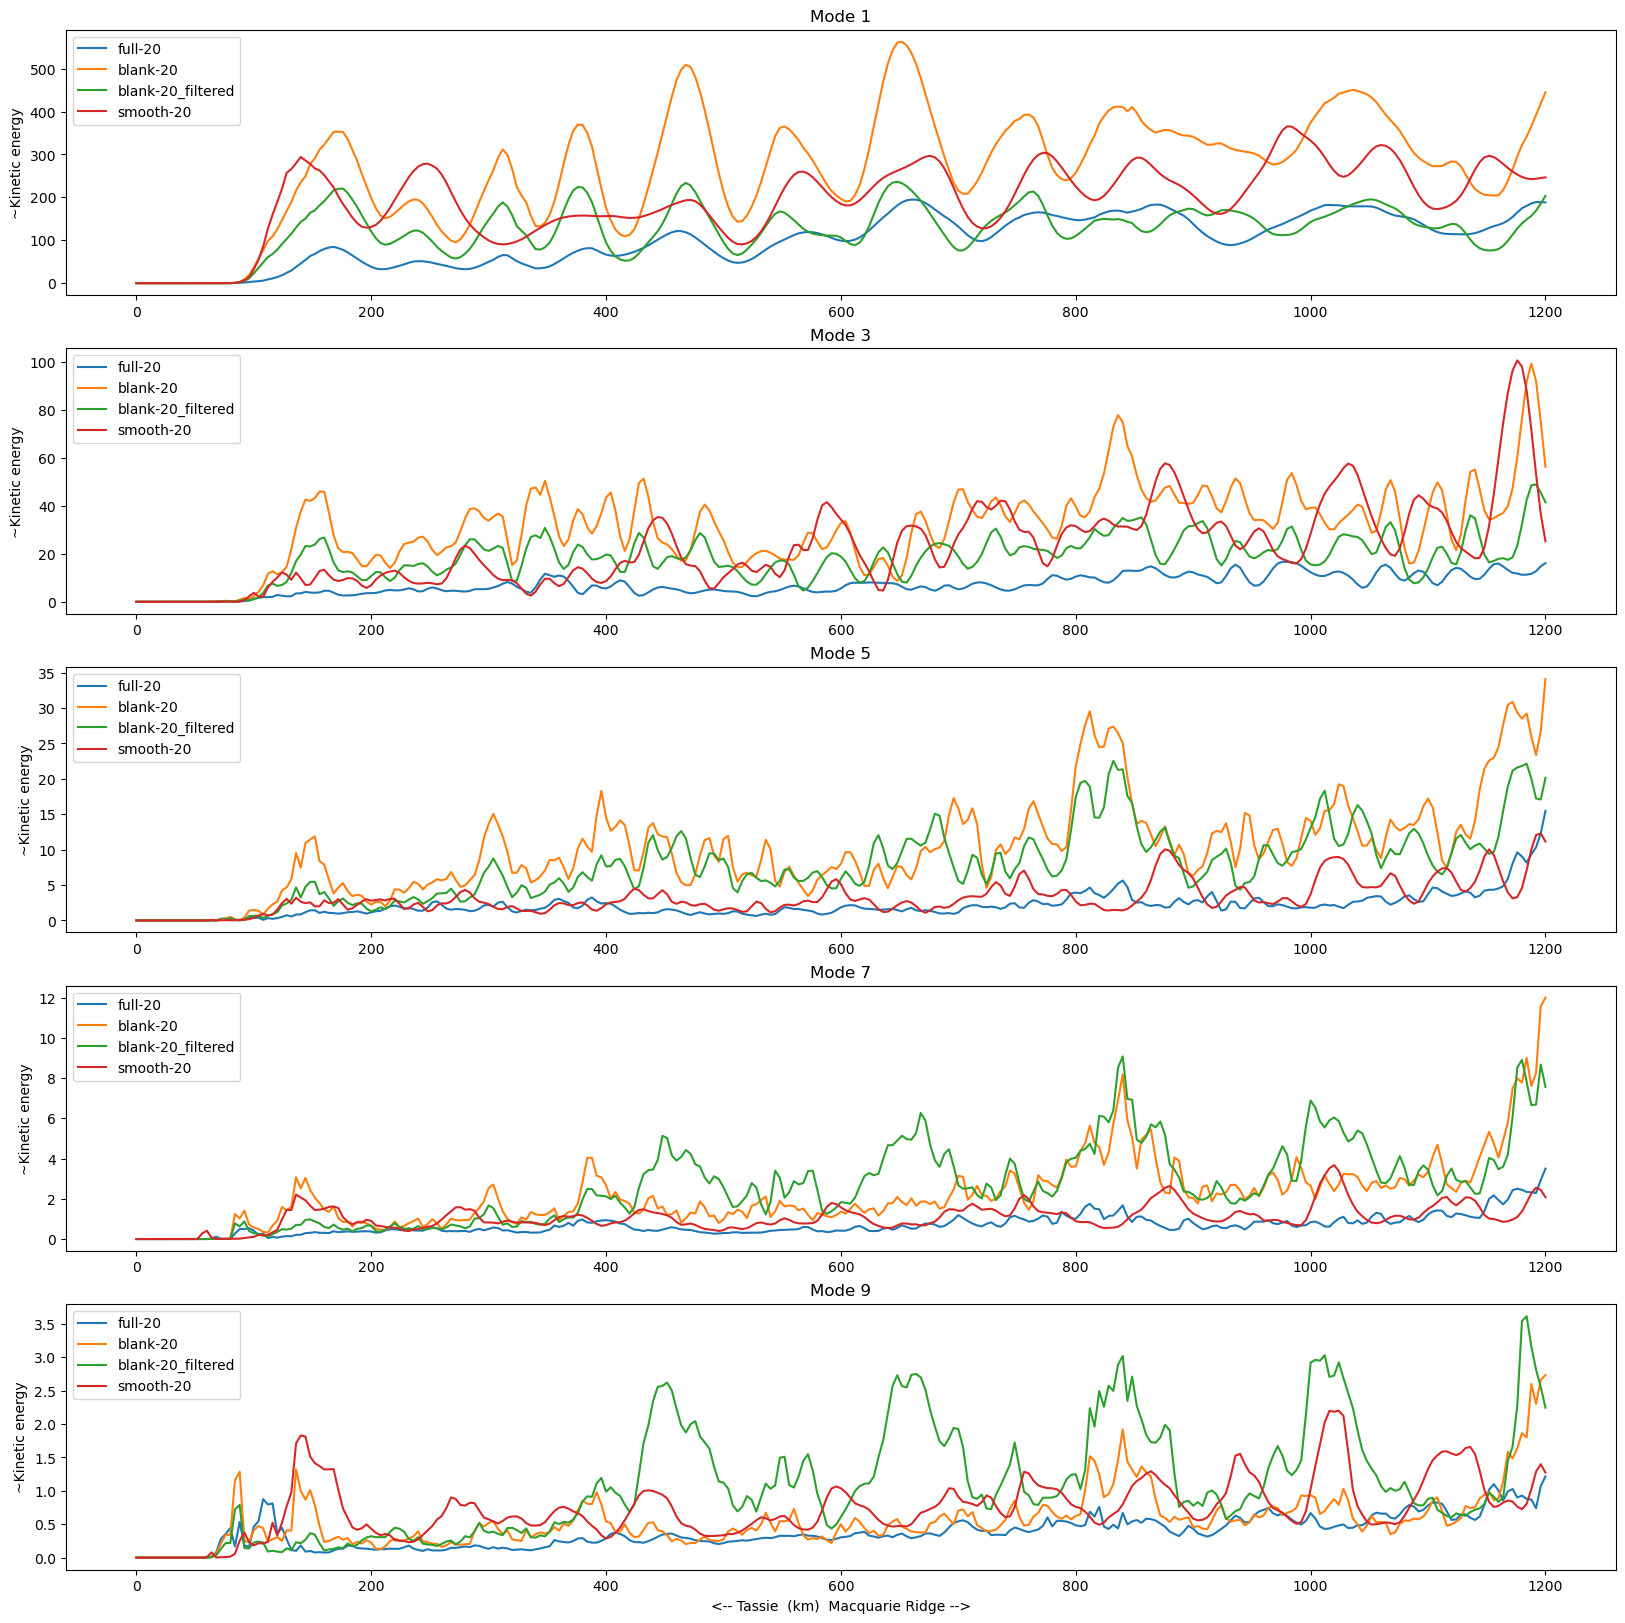

In [5]:
fig,ax = plt.subplots(5,figsize = (20,20))

for expt in to_process:
    if expt != "ideal-20":
        for i,mode in enumerate(range(1,10,2)):
            to_process[expt]["KE"].isel(mode = mode).integrate("zl").sel(xb = slice(0,1200)).plot(ax = ax[i],label = expt)

            ax[i].set_title(f"Mode {mode}")


            ax[i].legend()
            ax[i].set_ylabel("~Kinetic energy")
            ax[i].set_xlabel("")



ax[-1].set_xlabel("<-- Tassie  (km)  Macquarie Ridge -->")


2024-05-26 03:24:43,968 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-dc6bf84b9c814f782d9f801d733f5cce', 0),)
2024-05-26 03:24:44,148 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-dc6bf84b9c814f782d9f801d733f5cce', 0),)
2024-05-26 03:24:44,321 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-dc6bf84b9c814f782d9f801d733f5cce', 0),)


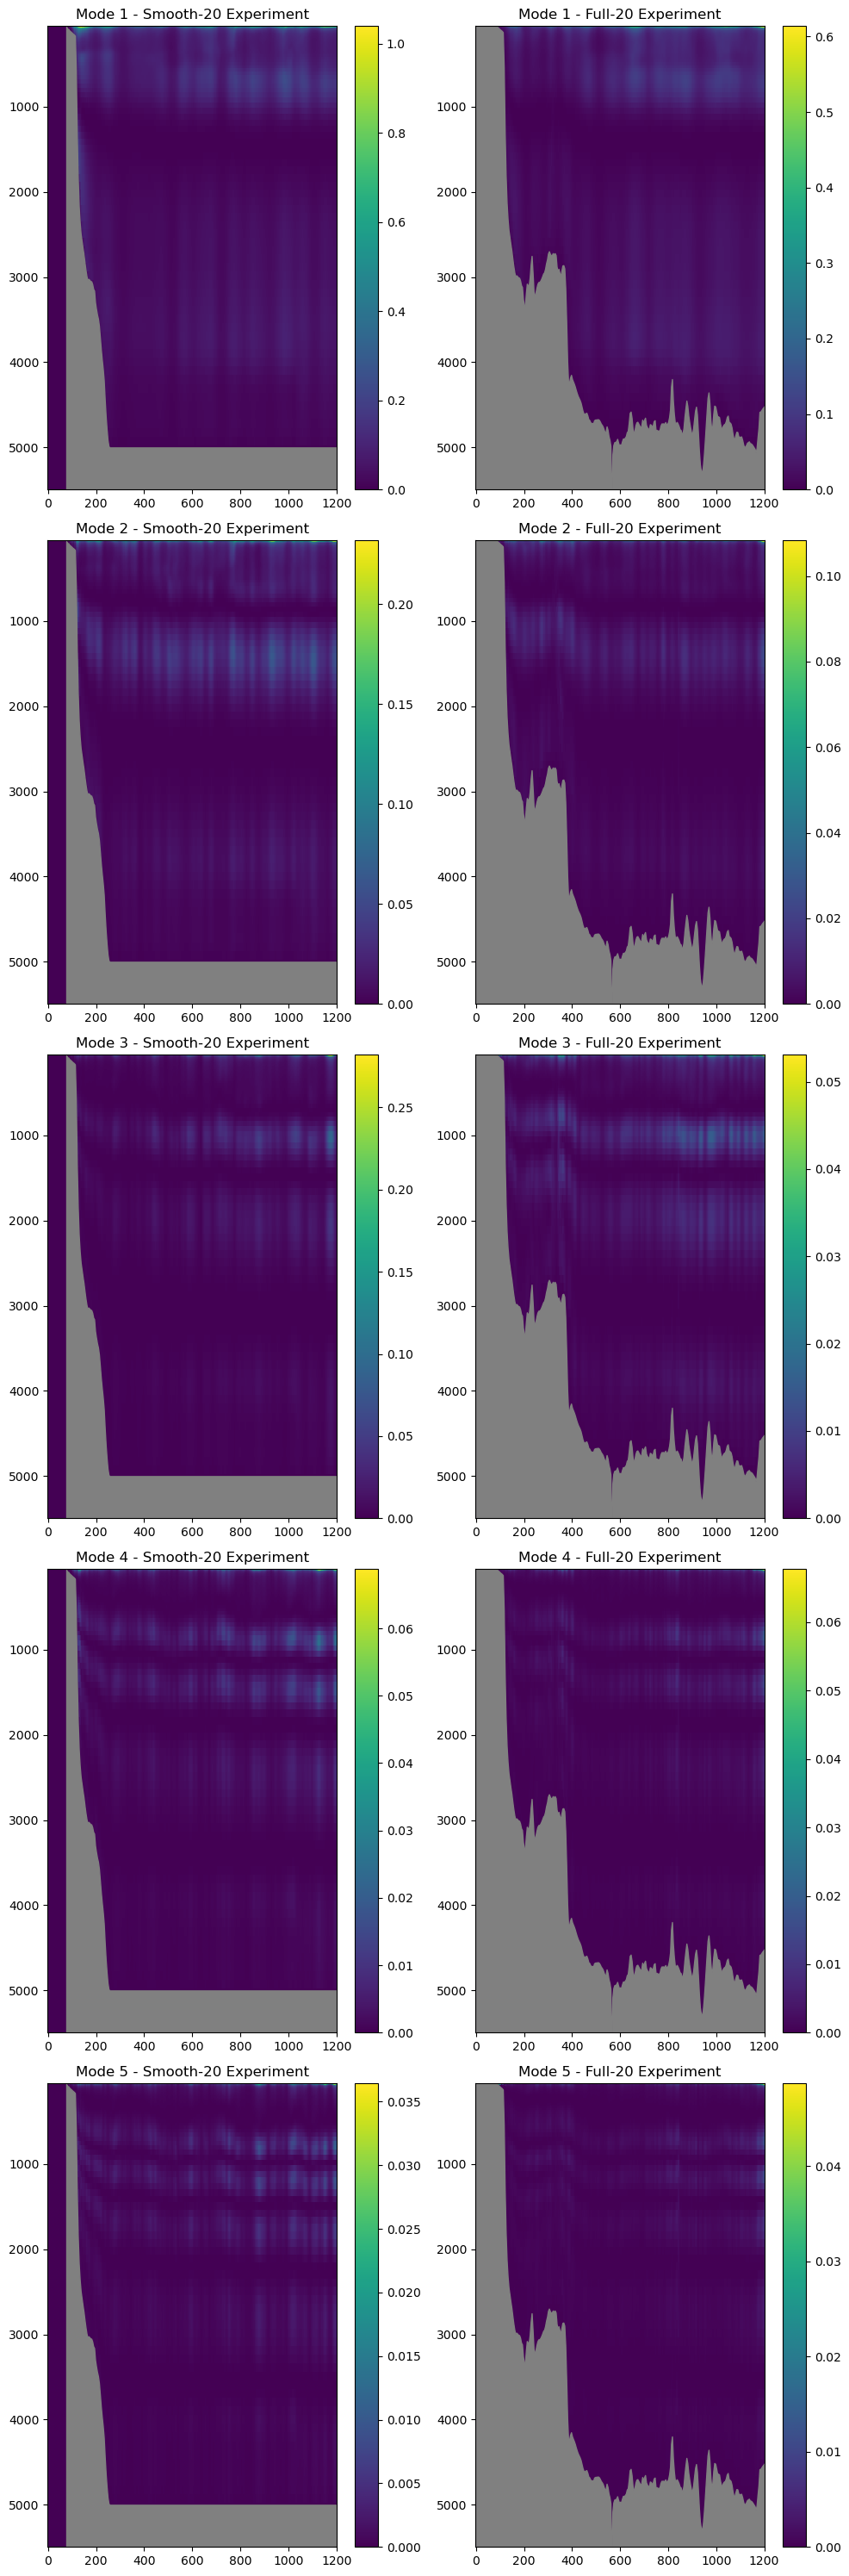

2024-05-26 04:05:44,307 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/worker.py", line 1252, in heartbeat
    response = await retry_operation(
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/utils_comm.py", line 452, in retry_operation
    return await retry(
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/utils_comm.py", line 431, in retry


In [7]:
fig, ax = plt.subplots(5, 2, figsize=(10, 30))

for i,mode in enumerate(range(1,6)):
    # Replace 'full_20_data[i]' and 'smooth_20_data[i]' with your actual data
    to_process["smooth-20"]["KE"].isel(mode = mode).sel(xb = slice(0,1200)).plot(ax = ax[i,0])
    to_process["full-20"]["KE"].isel(mode = mode).sel(xb = slice(0,1200)).plot(ax = ax[i,1])
    ax[i,0].fill_between(
        to_process["smooth-20"]["data"].bathy.xb,
        to_process["smooth-20"]["data"].bathy.sel(yb = 0,method = "nearest"),
        6000,color = "gray"
    )
    ax[i,1].fill_between(
        to_process["full-20"]["data"].bathy.xb,
        -1 * to_process["full-20"]["data"].bathy.sel(yb = 0,method = "nearest"),
        6000,color = "gray"
    )

    ax[i,0].invert_yaxis()
    ax[i,1].invert_yaxis()
    ax[i, 1].set_title(f'Mode {mode} - Full-20 Experiment')
    ax[i, 0].set_title(f'Mode {mode} - Smooth-20 Experiment')
    ax[i,0].set_xlabel("")
    ax[i,0].set_ylabel("")
    ax[i,1].set_ylabel("")
    ax[i,1].set_xlabel("")

plt.tight_layout()
plt.show()

2024-05-25 23:10:16,850 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-dc6bf84b9c814f782d9f801d733f5cce', 0),)


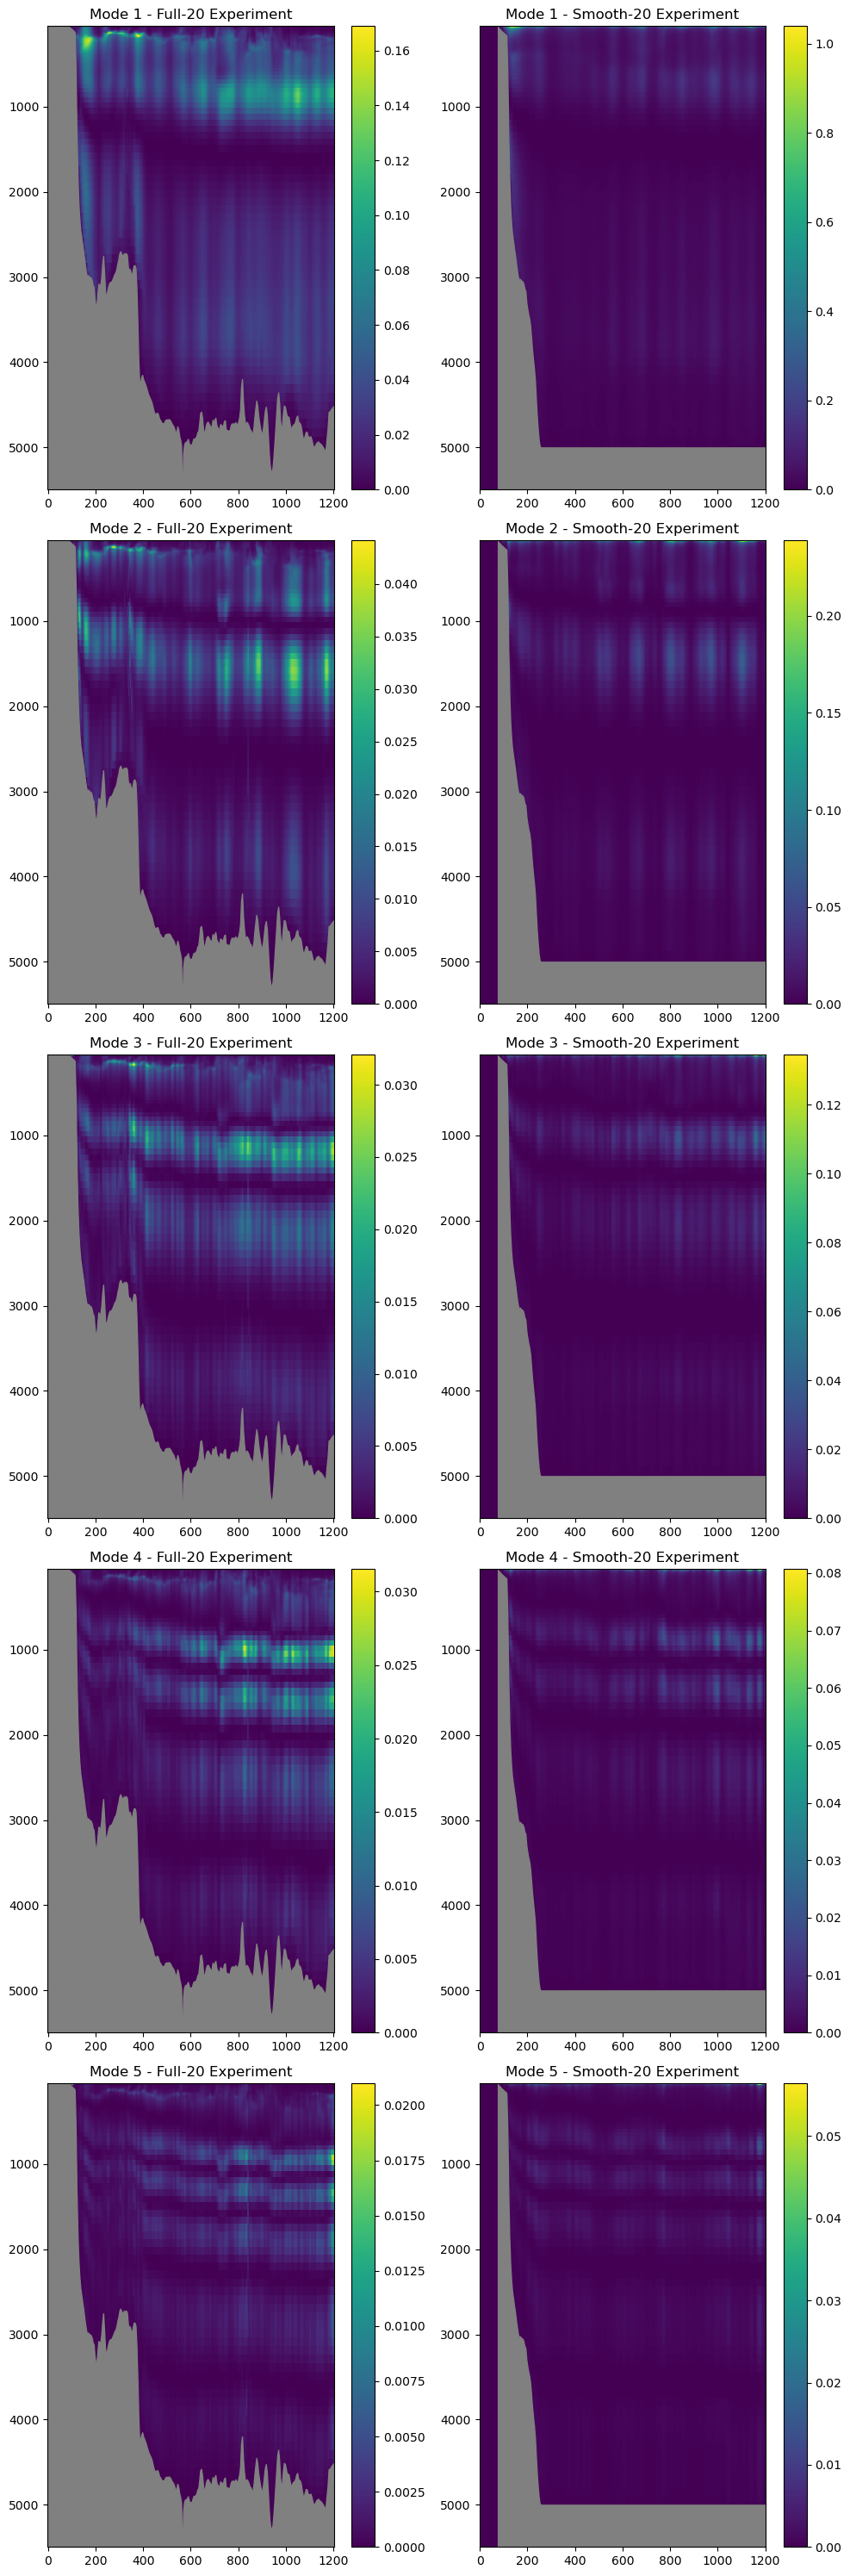

In [132]:
fig, ax = plt.subplots(5, 2, figsize=(10, 30))

for i,mode in enumerate(range(1,6)):
    # Replace 'full_20_data[i]' and 'smooth_20_data[i]' with your actual data
    to_process["full-20"]["KE"].isel(mode = mode).sel(xb = slice(0,1200)).plot(ax = ax[i,0])
    to_process["smooth-20"]["KE"].isel(mode = mode).sel(xb = slice(0,1200)).plot(ax = ax[i,1])
    ax[i,1].fill_between(
        to_process["smooth-20"]["data"].bathy.xb,
        to_process["smooth-20"]["data"].bathy.sel(yb = 0,method = "nearest"),
        6000,color = "gray"
    )
    ax[i,0].fill_between(
        to_process["full-20"]["data"].bathy.xb,
        -1 * to_process["full-20"]["data"].bathy.sel(yb = 0,method = "nearest"),
        6000,color = "gray"
    )

    ax[i,0].invert_yaxis()
    ax[i,1].invert_yaxis()
    ax[i, 0].set_title(f'Mode {mode} - Full-20 Experiment')
    ax[i, 1].set_title(f'Mode {mode} - Smooth-20 Experiment')
    ax[i,0].set_xlabel("")
    ax[i,0].set_ylabel("")
    ax[i,1].set_ylabel("")
    ax[i,1].set_xlabel("")

plt.tight_layout()
plt.show()

## Smooth experiment has heightened velocities near surface??

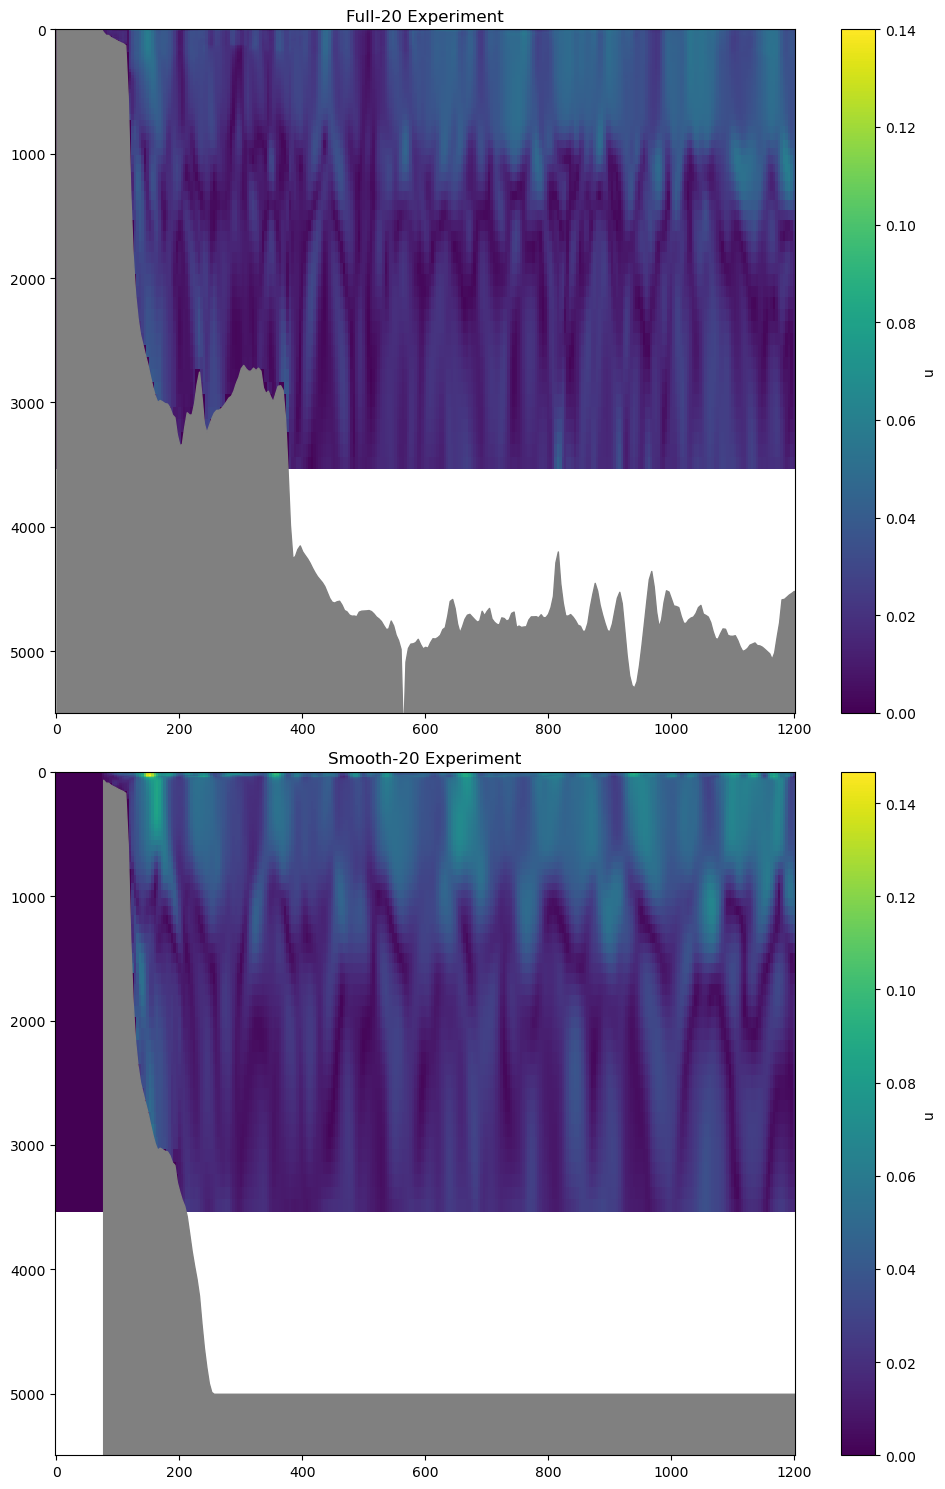

In [72]:
fig, ax = plt.subplots(2, figsize=(10, 15))


np.abs(to_process["full-20"]["data"].u).mean("time").sel(yb = 0,method = "nearest").sel(xb = slice(0,1200)).plot(ax = ax[0],vmax = 0.14)
np.abs(to_process["smooth-20"]["data"].u).mean("time").sel(yb = 0,method = "nearest").sel(xb = slice(0,1200)).plot(ax = ax[1])
ax[1].fill_between(
    to_process["smooth-20"]["data"].bathy.xb,
    to_process["smooth-20"]["data"].bathy.sel(yb = 0,method = "nearest"),
    6000,color = "gray"
)
ax[0].fill_between(
    to_process["full-20"]["data"].bathy.xb,
    -1 * to_process["full-20"]["data"].bathy.sel(yb = 0,method = "nearest"),
    6000,color = "gray"
)

ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_title(f'Full-20 Experiment')
ax[1].set_title(f'Smooth-20 Experiment')
ax[0].set_xlabel("")
ax[0].set_ylabel("")
ax[1].set_ylabel("")
ax[1].set_xlabel("")

plt.tight_layout()
plt.show()

Text(0.5, 0.98, 'Along Beam velocities at 50th layer down')

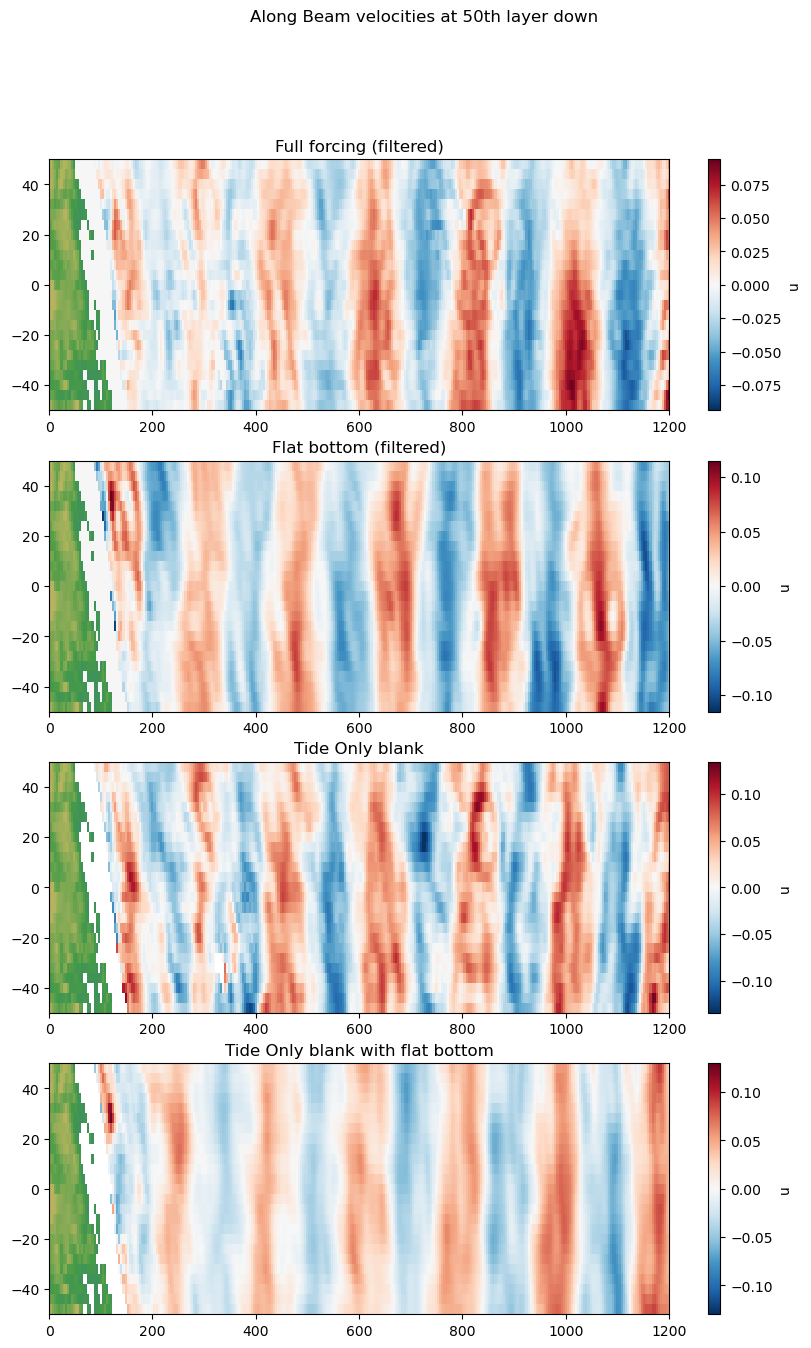

In [70]:
fig, ax = plt.subplots(4, figsize=(10, 15))


to_process["full-20"]["data"].u.isel(time = 5,zl = 50).sel(xb = slice(0,1200)).plot(ax = ax[0])
to_process["smooth-20"]["data"].u.isel(time = 5,zl = 50).sel(xb = slice(0,1200)).plot(ax = ax[1])
to_process["blank-20"]["data"].u.isel(time = 5,zl = 50).sel(xb = slice(0,1200)).plot(ax = ax[2])
to_process["ideal-20"]["data"].u.isel(time = 5,zl = 50).sel(xb = slice(0,1200)).plot(ax = ax[3])
for i in range(4):
    tt.plot_topo(ax[i],to_process["full-20"]["data"].bathy)
    ax[i].set_xlim(0,1200)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
ax[0].set_title(f'Full forcing (filtered)')
ax[1].set_title(f'Flat bottom (filtered)')
ax[2].set_title(f'Tide Only blank')
ax[3].set_title(f'Tide Only blank with flat bottom')
# fig.suptitle("Along Beam velocities at surface")
fig.suptitle("Along Beam velocities at 50th layer down")


loading u...	done.
loading u...	done.


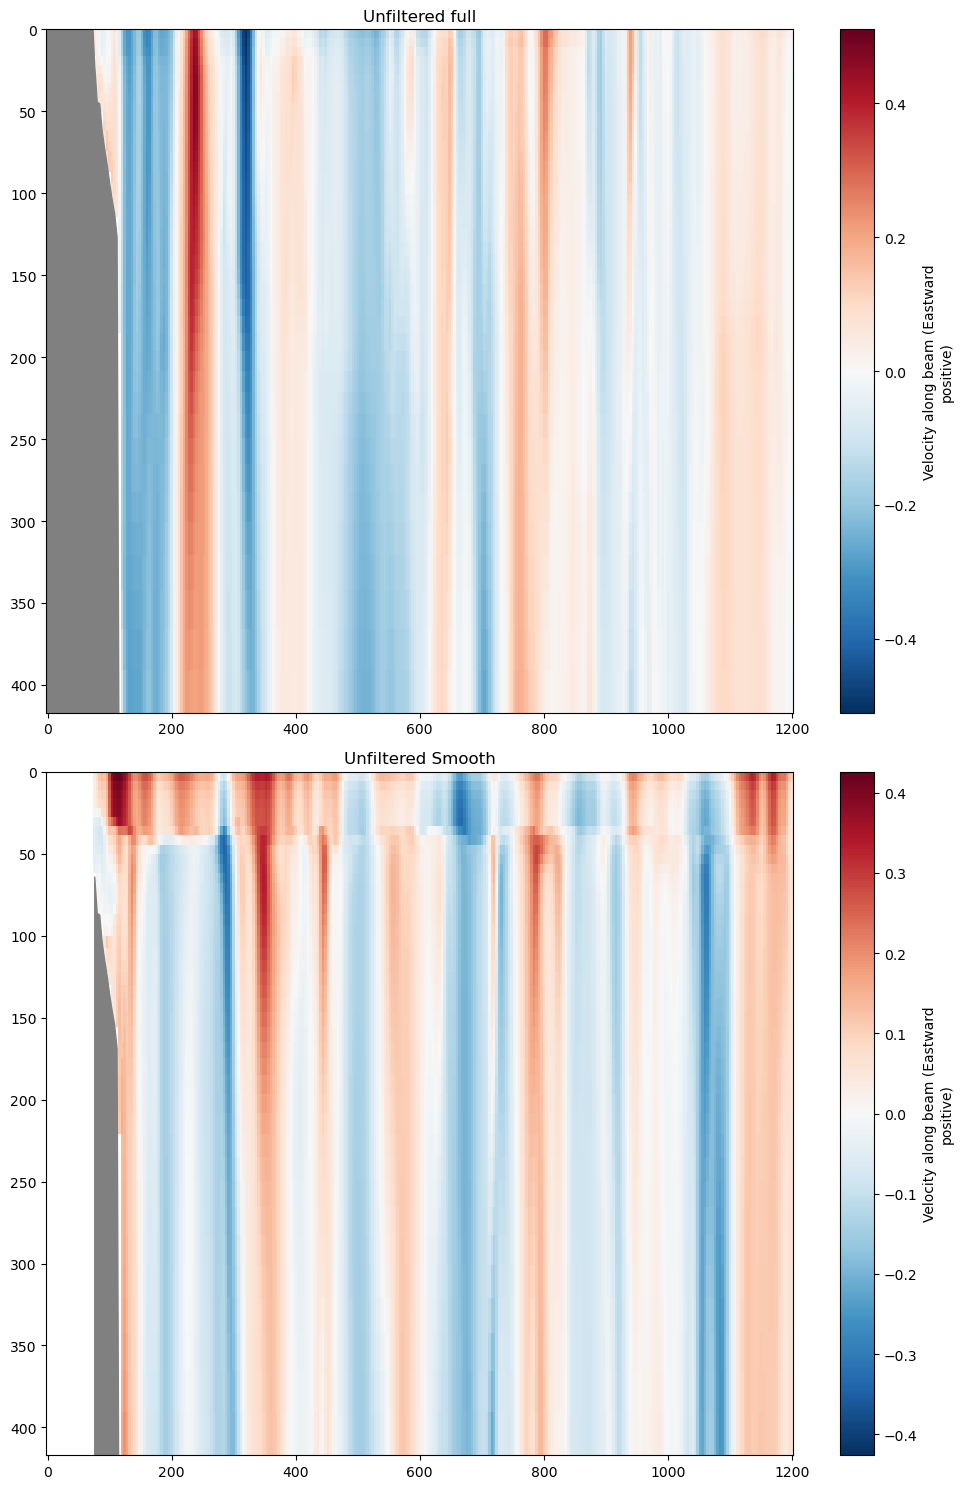

In [142]:
fig, ax = plt.subplots(2, figsize=(10, 15))
unfiltered_full = tt.collect_data("full-20",rawdata = ["u"],timerange = (40000-50,40000+50))
unfiltered_smooth = tt.collect_data("smooth-20",rawdata = ["u"],timerange = (10000-50,10000+50))

unfiltered_full.isel(time = 50,zl = slice(0,40)).u.sel(yb = 0,method = "nearest").sel(xb = slice(0,1200)).plot(ax = ax[0])
unfiltered_smooth.isel(time = 50,zl = slice(0,40)).u.sel(yb = 0,method = "nearest").sel(xb = slice(0,1200)).plot(ax = ax[1])
ax[1].fill_between(
    unfiltered_smooth.bathy.xb,
    unfiltered_smooth.bathy.sel(yb = 0,method = "nearest"),
    6000,color = "gray"
)
ax[0].fill_between(
    unfiltered_full.bathy.xb,
    -1 * unfiltered_full.bathy.sel(yb = 0,method = "nearest"),
    6000,color = "gray"
)

ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_title(f'Unfiltered full')
ax[1].set_title(f'Unfiltered Smooth')
ax[0].set_xlabel("")
ax[0].set_ylabel("")
ax[1].set_ylabel("")
ax[1].set_xlabel("")

plt.tight_layout()
plt.show()

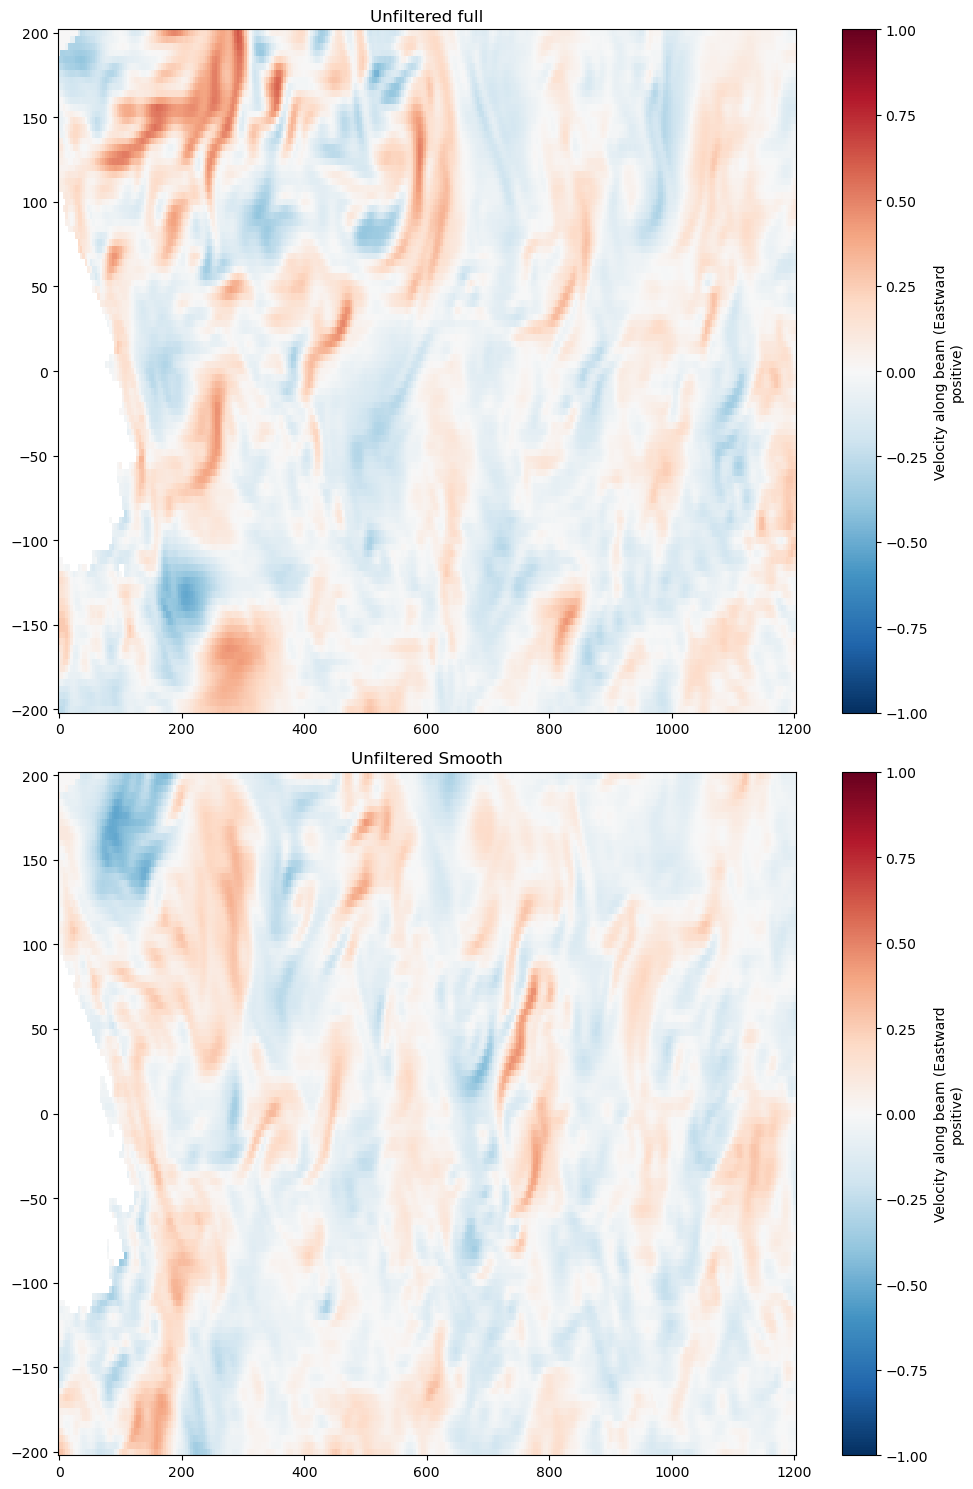

In [95]:
fig, ax = plt.subplots(2, figsize=(10, 15))

unfiltered_full.u.isel(time = 50).sel(zl = 50,method = "nearest").sel(xb = slice(0,1200)).plot(ax = ax[0],vmax = 1)
unfiltered_smooth.u.isel(time = 50).sel(zl = 50,method = "nearest").sel(xb = slice(0,1200)).plot(ax = ax[1],vmax = 1)
# ax[1].fill_between(
#     to_process["smooth-20"]["data"].bathy.xb,
#     to_process["smooth-20"]["data"].bathy.sel(yb = 0,method = "nearest"),
#     6000,color = "gray"
# )
# ax[0].fill_between(
#     to_process["full-20"]["data"].bathy.xb,
#     -1 * to_process["full-20"]["data"].bathy.sel(yb = 0,method = "nearest"),
#     6000,color = "gray"
# )

# ax[0].invert_yaxis()
# ax[1].invert_yaxis()
ax[0].set_title(f'Unfiltered full')
ax[1].set_title(f'Unfiltered Smooth')
ax[0].set_xlabel("")
ax[0].set_ylabel("")
ax[1].set_ylabel("")
ax[1].set_xlabel("")

plt.tight_layout()
plt.show()

loading u...	done.
loading u...	done.
loading u...	done.
loading u...	done.
loading u...	done.
loading u...	done.
loading u...	done.
loading u...	done.
loading u...	done.
loading u...	done.


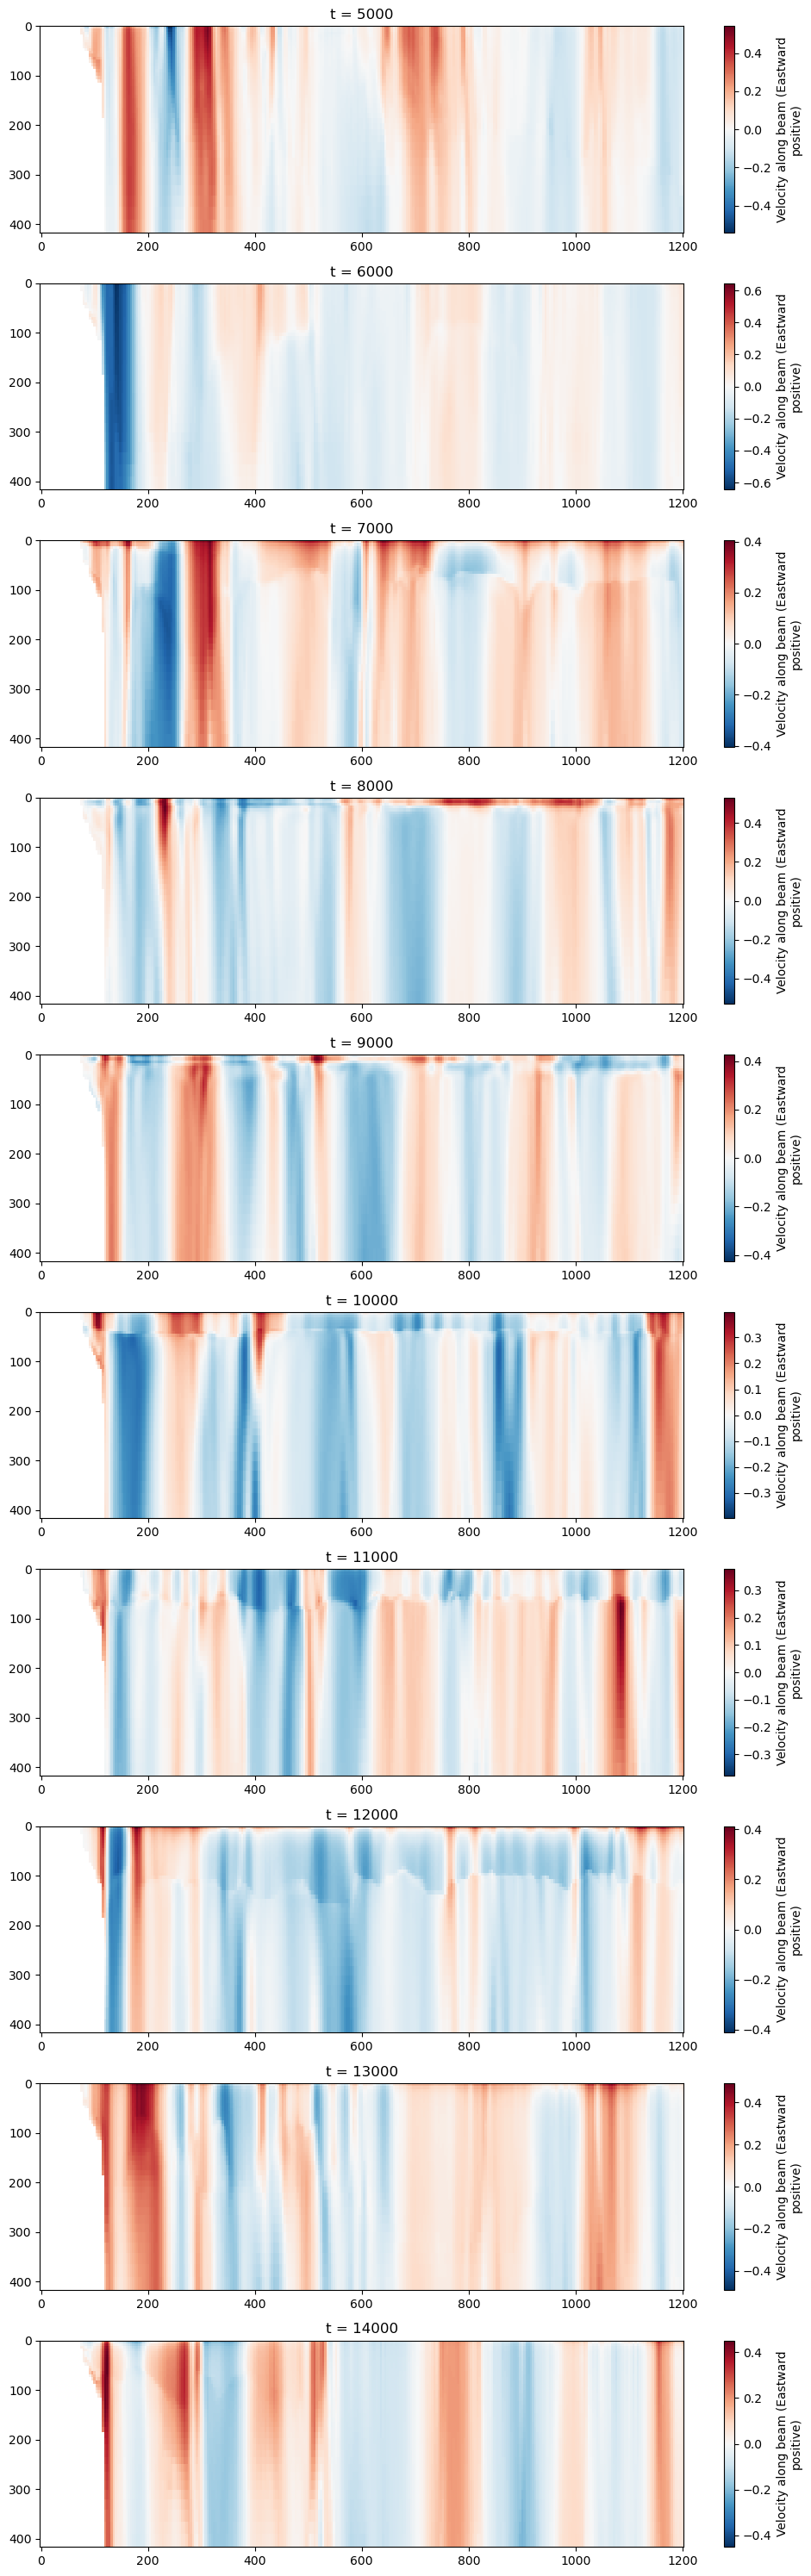

In [118]:
fig, ax = plt.subplots(10, figsize=(10, 30))

for i,j in enumerate(range(5000,15000,1000)):
    unfiltered_full = tt.collect_data("full-20",rawdata = ["u"],timerange = (j-50,j+50))
    unfiltered_full.isel(time = 50).u.sel(yb = 0,method = "nearest").sel(xb = slice(0,1200)).isel(zl = slice(0,40)).plot(ax = ax[i])
    # ax[i].fill_between(
    #     unfiltered_full.bathy.xb,
    #     -1 * unfiltered_full.bathy.sel(yb = 0,method = "nearest"),
    #     6000,color = "gray"
    # )
    ax[i].set_title(f"t = {j}")
    ax[i].invert_yaxis()
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")

fig.tight_layout()


In [ ]:
(25 * 15)

In [126]:
print(5000 / (24 * 15))
print(10000 / (24 * 15))
print(4 * 15 * 0.88)
print(4 * 15 * 0.77)

13.88888888888889
27.77777777777778
52.8
46.2


Text(0.5, 0, '')

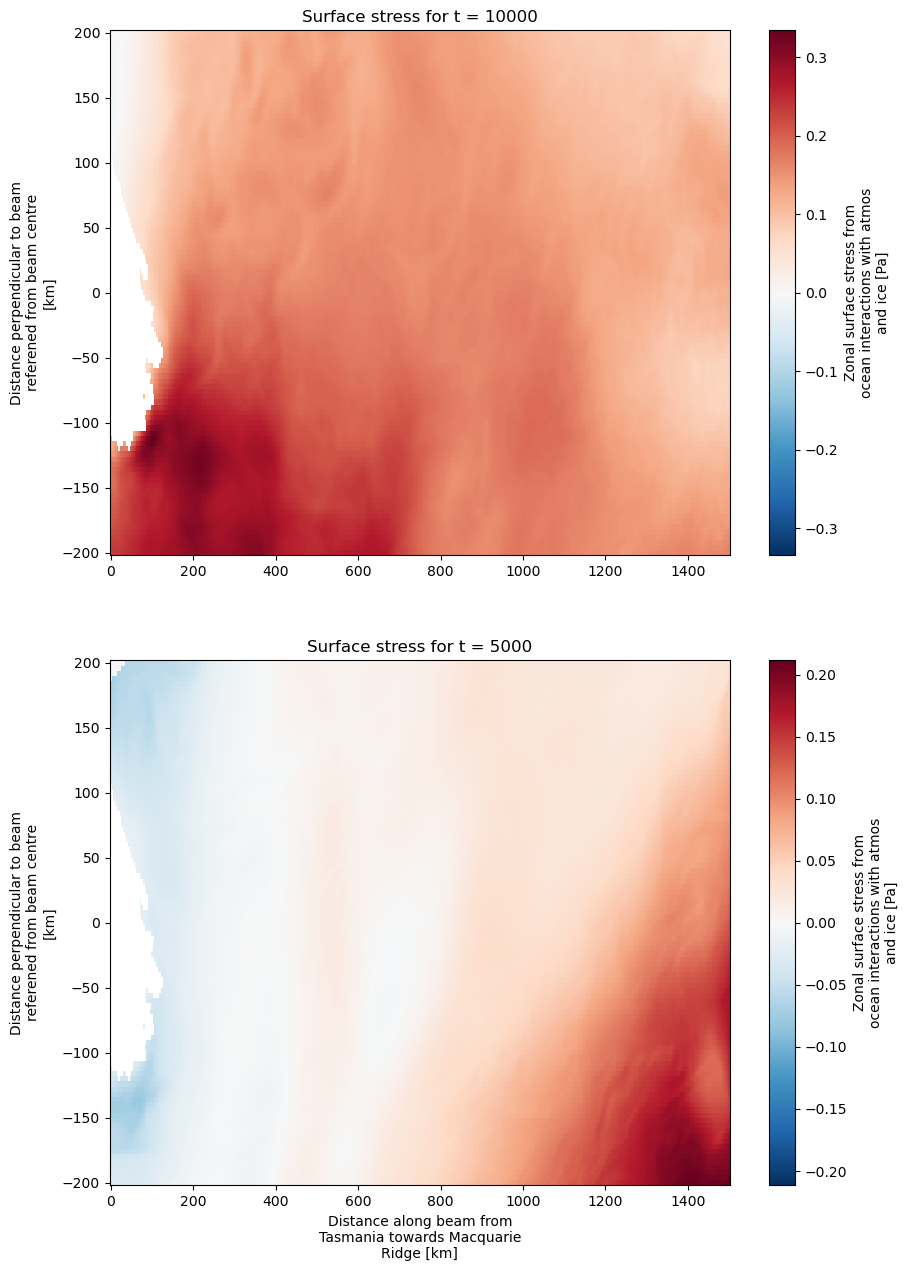

In [127]:
taux1 = xr.open_mfdataset("/g/data/nm03/ab8992/outputs/full-20/output027/surface_transect.nc",decode_times = False)
taux2 = xr.open_mfdataset("/g/data/nm03/ab8992/outputs/full-20/output013/surface_transect.nc",decode_times = False)

# plot both of these
fig, ax = plt.subplots(2, figsize=(10, 15))
taux1.taux.isel(time = 46).plot(ax = ax[0])
taux2.taux.isel(time = 53).plot(ax = ax[1])

ax[0].set_title(f"Surface stress for t = 10000")
ax[1].set_title(f"Surface stress for t = 5000")
ax[0].set_xlabel(f"")
